In [334]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from astropy.io import fits,ascii
import pandas as pd
import cmasher as cmr
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import pingouin

In [335]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_s05.csv")
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
galfit = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
ssp = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv('/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv')
master = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_master_source_catalogue.csv",skiprows=16)
prospect = prospect[prospect['MAGPIID'].isin(sample["MAGPIID"])]
galfit = galfit[galfit["MAGPIID"].isin(sample["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp = ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]
master = master[master['MAGPIID'].isin(sample["MAGPIID"])]

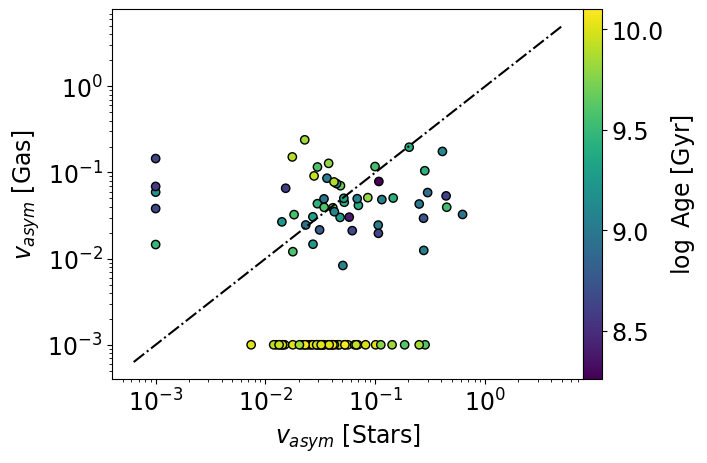

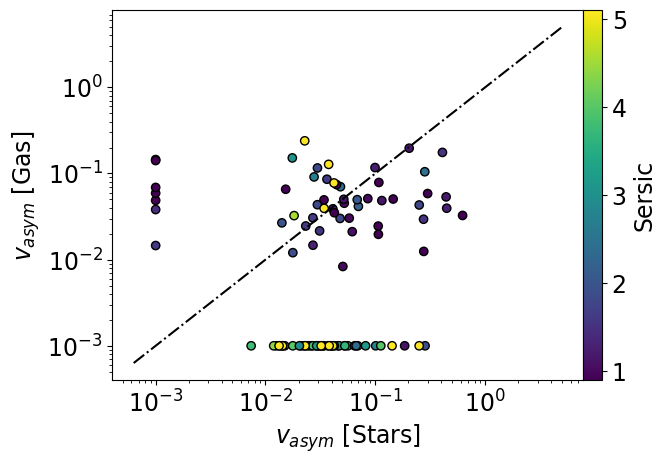

In [336]:
vs = sample["v_asym_s"].to_numpy()
vg = sample["v_asym_g"].to_numpy()
vs[np.isnan(vs)]=1e-3
vg[np.isnan(vg)]=1e-3
fig,ax=plt.subplots()
p=ax.scatter(vs,vg,c=ssp["logage_LW_1re"],ec="k")
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
cbar = plt.colorbar(p,ax=ax,fraction=0.05,pad=0.00,label=r"$\log$ Age [Gyr]")
#cbar.ax.set_yticklabels([8.95,9.05,9.15,9.25,9.35,9.45,9.55,9.65,9.75])
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/s05_gas_stars_age.pdf",bbox_inches="tight")

fig,ax=plt.subplots()
p=ax.scatter(vs,vg,c=galfit["n"],vmin=0.9,vmax=5.1,ec="k")
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
plt.colorbar(p,ax=ax,fraction=0.05,pad=0.00,label="Sersic")
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/s05_gas_stars_sersic.pdf",bbox_inches="tight")

In [286]:
galfit["n"]

13      3.30
14      7.93
21      1.11
29      1.77
52      1.59
        ... 
1654    4.55
1671    2.07
1697    8.00
1701    5.86
1718    1.59
Name: n, Length: 100, dtype: float64

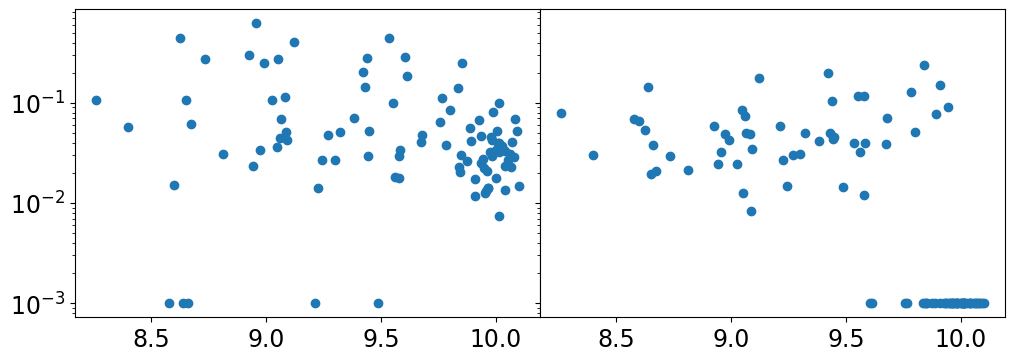

In [333]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey="row",figsize=(12,4))
ax1.scatter(ssp["logage_LW_1re"],vs)
ax1.set_yscale("log")
ax2.scatter(ssp["logage_LW_1re"],vg)
ax2.set_yscale("log")
plt.subplots_adjust(wspace=0)
plt.show()